# Data preprocessing: more art than science?

## Contents of this notebook:
<ol>
<li>Load and examine your data</li>
<li>Merging two dataframes</li>
<li>Removing features that you do not need</li>
<li>Making your data machine-readable</li>
<li>Handling not available (NA) and inf data</li>
<li>Removing columns with a standard deviation of 0</li>
<li>Feature scaling</li>
<li>Data visualization</li>
<li>Loading local files into Google Colab</li>
<li>Mini assignment: data visualization</li>
</ol>

## 1. Load and examine your data

### 1.1 Preliminary examination of your data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

df = pd.read_csv("data_csv/unrestricted_HCP_behavioral.csv")

Quick quality check: is the dataframe shape what you expect it to be? You should know how many subjects (ie rows) and features (ie columns) you are expecting your dataframe (`df`) to have prior to any downstream analysis.

In [2]:
print(f"df type: {type(df)}")
print(f"df shape: {df.shape}")

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (1206, 499)


In [3]:
df.head(4)

,Subject,Gender,Age,MMSE_Score,PSQI_Score,PSQI_Comp1,PSQI_Comp2,PSQI_Comp3,PSQI_Comp4,PSQI_Comp5,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,M,22-25,29,8,1,2,2,1,1,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,M,26-30,30,6,1,1,1,1,1,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,F,26-30,29,4,1,0,1,0,2,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,M,31-35,30,4,1,1,0,0,1,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68


In [4]:
df.tail(4)

,Subject,Gender,Age,MMSE_Score,PSQI_Score,PSQI_Comp1,PSQI_Comp2,PSQI_Comp3,PSQI_Comp4,PSQI_Comp5,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
1202,993675,F,26-30,30,4,1,1,1,0,1,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76
1203,994273,M,26-30,28,8,1,1,0,0,2,...,6.0,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76
1204,995174,M,22-25,26,7,1,2,0,0,1,...,3.6,88.61,64.58,3.0,50.1,117.16,117.40,1.80,0.0,1.80
1205,996782,F,26-30,30,4,1,1,1,0,1,...,6.0,108.79,97.19,0.0,38.6,75.43,73.72,1.84,0.0,1.84


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Columns: 499 entries, Subject to Mars_Final
dtypes: float64(410), int64(25), object(64)
memory usage: 4.6+ MB


In [6]:
df.describe()

,Subject,MMSE_Score,PSQI_Score,PSQI_Comp1,PSQI_Comp2,PSQI_Comp3,PSQI_Comp4,PSQI_Comp5,PSQI_Comp6,PSQI_Comp7,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,...,1196.000000,1204.000000,1204.000000,1201.000000,1205.000000,1200.000000,1200.000000,1198.000000,1195.000000,1195.000000
mean,374551.585406,28.985904,4.854892,0.903814,0.981758,0.575456,0.466003,1.105307,0.235489,0.587065,...,4.404682,110.421321,97.727500,1.449625,45.847718,95.166983,93.998533,1.845467,0.581590,1.822251
std,272686.898230,1.048516,2.802134,0.631696,0.828736,0.817157,0.807694,0.510167,0.671359,0.637916,...,1.513823,9.107963,11.273251,1.783069,7.679288,14.583412,14.837851,0.541393,0.973172,0.542893
min,100004.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.400000,82.740000,59.860000,0.000000,38.600000,56.350000,59.500000,1.560000,0.000000,1.080000
25%,154254.250000,28.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,3.600000,101.120000,87.110000,0.000000,38.600000,84.070000,83.220000,1.800000,0.000000,1.760000
50%,212166.500000,29.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,4.400000,108.790000,98.040000,1.000000,45.900000,95.360000,94.970000,1.800000,0.000000,1.800000
75%,586310.500000,30.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,5.200000,122.250000,110.450000,2.000000,52.200000,105.570000,102.920000,1.880000,1.000000,1.840000
max,996782.000000,30.000000,19.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,14.000000,122.250000,111.410000,10.000000,75.300000,134.650000,131.380000,15.000000,17.000000,15.000000


In [7]:
df.columns

Index(['Subject', 'Gender', 'Age', 'MMSE_Score', 'PSQI_Score', 'PSQI_Comp1',
       'PSQI_Comp2', 'PSQI_Comp3', 'PSQI_Comp4', 'PSQI_Comp5',
       ...
       'Noise_Comp', 'Odor_Unadj', 'Odor_AgeAdj', 'PainIntens_RawScore',
       'PainInterf_Tscore', 'Taste_Unadj', 'Taste_AgeAdj', 'Mars_Log_Score',
       'Mars_Errs', 'Mars_Final'],
      dtype='object', length=499)

In [8]:
df['Gender'].unique()

array(['M', 'F'], dtype=object)

In [9]:
df['Gender'].value_counts()

F    656
M    550
Name: Gender, dtype: int64

In [10]:
df[df['Gender']=="F"] # Display only the rows of female subjects

,Subject,Gender,Age,MMSE_Score,PSQI_Score,PSQI_Comp1,PSQI_Comp2,PSQI_Comp3,PSQI_Comp4,PSQI_Comp5,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
2,100307,F,26-30,29,4,1,0,1,0,2,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
5,101006,F,31-35,28,2,1,1,0,0,0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
7,101208,F,31-35,30,6,1,2,0,0,2,...,4.4,101.12,87.11,1.0,50.1,105.57,102.32,1.92,0.0,1.92
10,101612,F,26-30,28,4,1,1,0,0,1,...,4.4,122.25,111.41,2.0,48.7,97.26,96.41,1.84,0.0,1.84
11,101915,F,31-35,29,6,1,1,1,1,1,...,4.4,96.87,77.61,0.0,38.6,112.11,111.70,1.84,1.0,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,984472,F,26-30,30,5,1,1,1,0,1,...,2.8,122.25,110.45,0.0,38.6,108.73,108.00,1.76,0.0,1.76
1196,987983,F,26-30,30,3,1,1,0,0,1,...,5.2,108.79,97.19,5.0,56.4,88.02,87.70,1.88,0.0,1.88
1200,992673,F,31-35,30,0,0,0,0,0,0,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
1202,993675,F,26-30,30,4,1,1,1,0,1,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


### 1.2 Documentation
Woah! So many columns and abbreviations! What do they all mean? Make sure you know where your [dataset's documentation](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release#HCPYADataDictionaryUpdatedforthe1200SubjectRelease-Instrument:Demographics) is.

Unfortunately, thorough documentation is not always available. Some data types are also very field-specific and require the help of experts, which is part of what makes machine learning so wonderfully interdisciplinary.

In [11]:
df.columns

Index(['Subject', 'Gender', 'Age', 'MMSE_Score', 'PSQI_Score', 'PSQI_Comp1',
       'PSQI_Comp2', 'PSQI_Comp3', 'PSQI_Comp4', 'PSQI_Comp5',
       ...
       'Noise_Comp', 'Odor_Unadj', 'Odor_AgeAdj', 'PainIntens_RawScore',
       'PainInterf_Tscore', 'Taste_Unadj', 'Taste_AgeAdj', 'Mars_Log_Score',
       'Mars_Errs', 'Mars_Final'],
      dtype='object', length=499)

Handpicking the columns you want to work with:

In [12]:
basics = ['Subject','Gender','Age','PSQI_BedTime']
df[basics]

,Subject,Gender,Age,PSQI_BedTime
0,100004,M,22-25,9:00:00
1,100206,M,26-30,22:30:00
2,100307,F,26-30,22:00:00
3,100408,M,31-35,22:00:00
4,100610,M,26-30,21:30:00
...,...,...,...,...
1201,992774,M,31-35,22:00:00
1202,993675,F,26-30,22:00:00
1203,994273,M,26-30,2:00:00
1204,995174,M,22-25,23:00:00


Let's also add all of some cognitive variables to the mix! Specifically, we'll select the measures related to fluid intelligence (they start with `PMAT` for Penn Matrix Test) and impulsivity (they start with `DDisc` for Delay Discounting)

In [13]:
cognition = ['Subject','Gender','Age','PSQI_BedTime']
for col in df.columns:
    if (col.find("PMAT")!=-1 or col.find("DDisc")!=-1):
        cognition.append(col)
print(f"List of variables we will be looking at: {cognition}") # PS: f-strings will be very useful for you in your Python journey!

List of variables we will be looking at: ['Subject', 'Gender', 'Age', 'PSQI_BedTime', 'PMAT24_A_CR', 'PMAT24_A_SI', 'PMAT24_A_RTCR', 'DDisc_SV_1mo_200', 'DDisc_SV_6mo_200', 'DDisc_SV_1yr_200', 'DDisc_SV_3yr_200', 'DDisc_SV_5yr_200', 'DDisc_SV_10yr_200', 'DDisc_SV_1mo_40K', 'DDisc_SV_6mo_40K', 'DDisc_SV_1yr_40K', 'DDisc_SV_3yr_40K', 'DDisc_SV_5yr_40K', 'DDisc_SV_10yr_40K', 'DDisc_AUC_200', 'DDisc_AUC_200.1', 'DDisc_AUC_40K']


Okay! So let's actually select this subset of our data, and make it a separate dataframe!

In [14]:
df_cognition = df[cognition]

In [15]:
df_cognition.head()

,Subject,Gender,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,...,DDisc_SV_10yr_200,DDisc_SV_1mo_40K,DDisc_SV_6mo_40K,DDisc_SV_1yr_40K,DDisc_SV_3yr_40K,DDisc_SV_5yr_40K,DDisc_SV_10yr_40K,DDisc_AUC_200,DDisc_AUC_200.1,DDisc_AUC_40K
0,100004,M,22-25,9:00:00,19.0,0.0,15590.0,153.13,46.88,21.88,...,21.88,34375.0,24375.0,625.0,625.0,625.0,625.0,0.121811,0.121811,0.067448
1,100206,M,26-30,22:30:00,20.0,0.0,18574.5,78.13,34.38,9.38,...,9.38,30625.0,625.0,625.0,3125.0,625.0,625.0,0.097072,0.097072,0.050000
2,100307,F,26-30,22:00:00,17.0,2.0,11839.0,103.13,46.88,103.13,...,9.38,19375.0,29375.0,24375.0,9375.0,9375.0,9375.0,0.162176,0.162176,0.311459
3,100408,M,31-35,22:00:00,7.0,12.0,3042.0,153.13,46.88,46.88,...,9.38,39375.0,29375.0,24375.0,19375.0,18125.0,4375.0,0.203061,0.203061,0.421354
4,100610,M,26-30,21:30:00,23.0,0.0,12280.0,196.88,196.88,184.38,...,146.88,39375.0,39375.0,39375.0,39375.0,36875.0,24375.0,0.801629,0.801629,0.868750


In [16]:
df_cognition.shape

(1206, 22)

### 2. Merging two dataframes

So for our dataset of 1206 subjects, we have information about their gender, age-range and a variety of cognitive measures. It would be cool to be able to integrate some other data as well. You have been provided with a separate file that contains brain structure volume data obtained from the neuroimaging data of these same subjects (note that not all subjects in the HCP have neuroimaging data)

In [17]:
df_volumes = pd.read_csv("data_csv/HCP_volumes.csv")

In [18]:
df_volumes

,Subject,TBV,Gp_Left,Gp_Right,Str_Left,Str_Right,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA
0,100206,1694580,1746.90,1597.69,11848.20,12030.00,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646
1,100307,1319380,1489.99,1291.05,9470.57,9749.09,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277
2,100408,1563630,1617.93,1531.84,10274.90,10693.40,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635
3,100610,1585390,1841.22,1639.88,12464.30,12575.80,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274
4,101006,1261040,1679.33,1571.28,9774.47,9967.58,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,992774,1328640,1401.50,1266.36,9735.71,9799.51,6253.92,6234.37,13763.48378,14650.11549,6814.085943,7170.076369,3198.083973,3262.912737
1082,993675,1257810,1394.98,1326.72,9093.62,9385.51,5994.61,5971.29,12477.92590,13833.70956,6601.958682,7131.259938,2995.664299,3186.251544
1083,994273,1487180,1646.74,1501.31,11164.60,11670.90,6711.82,6886.75,14637.99165,16242.63411,7100.454111,7637.944904,3441.358390,3549.415428
1084,995174,1517230,1678.30,1594.26,11154.40,11338.60,6766.36,6734.46,14516.88893,15906.36860,7263.501869,7809.016115,3535.013585,3761.052946


In [19]:
df_volumes['TBV'].mean() # mean TBV!

1406181.3996316758

In [20]:
df_volumes['TBV'].std() # standard deviation of TBV!

151214.50029241372

List all our subjects whose TBV is above average! (PS: another way to write this: `df_volumes[df_volumes['TBV']>1406181]`)

In [21]:
df_volumes[df_volumes['TBV']>df_volumes['TBV'].mean()]

,Subject,TBV,Gp_Left,Gp_Right,Str_Left,Str_Right,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA
0,100206,1694580,1746.90,1597.69,11848.20,12030.00,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646
2,100408,1563630,1617.93,1531.84,10274.90,10693.40,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635
3,100610,1585390,1841.22,1639.88,12464.30,12575.80,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274
6,101309,1426200,1690.65,1507.14,10144.90,10251.60,6266.95,6182.92,13848.22982,15324.77410,6798.623361,7329.928997,3582.231784,3677.827998
7,101410,1588370,1440.26,1328.78,9376.25,9713.07,6865.83,6683.70,13217.76480,14592.03987,7153.875176,7624.042048,3143.810997,3339.830347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,987074,1451930,1541.44,1384.69,10053.70,10266.00,6290.62,6012.10,13970.55221,14972.19121,7221.456229,7054.193554,3353.157608,3502.805296
1079,991267,1802370,1804.52,1681.04,12363.10,12466.30,7433.50,7367.64,15554.95026,16965.02114,7649.207918,8214.273885,3620.911699,3828.376050
1083,994273,1487180,1646.74,1501.31,11164.60,11670.90,6711.82,6886.75,14637.99165,16242.63411,7100.454111,7637.944904,3441.358390,3549.415428
1084,995174,1517230,1678.30,1594.26,11154.40,11338.60,6766.36,6734.46,14516.88893,15906.36860,7263.501869,7809.016115,3535.013585,3761.052946


Ok! Let's merge our dataframes. Do they have the same number of subjects?

In [22]:
print(df_volumes.shape)
print(df_cognition.shape)

(1086, 14)
(1206, 22)


No! We only have volume data for 1086 subjects... So how do we create a new dataframe, where we only keep the subjects for which we have all of our features?

In [23]:
df_final=pd.merge(df_cognition,df_volumes, on='Subject')
df_final.head()

,Subject,Gender,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,...,Str_Left,Str_Right,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA
0,100206,M,26-30,22:30:00,20.0,0.0,18574.5,78.13,34.38,9.38,...,11848.20,12030.00,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646
1,100307,F,26-30,22:00:00,17.0,2.0,11839.0,103.13,46.88,103.13,...,9470.57,9749.09,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277
2,100408,M,31-35,22:00:00,7.0,12.0,3042.0,153.13,46.88,46.88,...,10274.90,10693.40,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635
3,100610,M,26-30,21:30:00,23.0,0.0,12280.0,196.88,196.88,184.38,...,12464.30,12575.80,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274
4,101006,F,31-35,23:00:00,11.0,8.0,6569.0,140.63,96.88,115.63,...,9774.47,9967.58,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259


In [24]:
df_final.shape

(1086, 35)

Mission accomplished! We have 1086 and 14 + 22 features. 

## 3. Removing features that you do not need

In [25]:
df_final.columns

Index(['Subject', 'Gender', 'Age', 'PSQI_BedTime', 'PMAT24_A_CR',
       'PMAT24_A_SI', 'PMAT24_A_RTCR', 'DDisc_SV_1mo_200', 'DDisc_SV_6mo_200',
       'DDisc_SV_1yr_200', 'DDisc_SV_3yr_200', 'DDisc_SV_5yr_200',
       'DDisc_SV_10yr_200', 'DDisc_SV_1mo_40K', 'DDisc_SV_6mo_40K',
       'DDisc_SV_1yr_40K', 'DDisc_SV_3yr_40K', 'DDisc_SV_5yr_40K',
       'DDisc_SV_10yr_40K', 'DDisc_AUC_200', 'DDisc_AUC_200.1',
       'DDisc_AUC_40K', 'TBV', 'Gp_Left', 'Gp_Right', 'Str_Left', 'Str_Right',
       'Thal_Left', 'Thal_Right', 'str_left_SA', 'str_right_SA',
       'thal_left_SA', 'thal_right_SA', 'gp_left_SA', 'gp_right_SA'],
      dtype='object')

Do we have any columns that repeat themselves? Yes we do! `DDisc_AUC_200` and `DDisc_AUC_200.1` might be the same. Let's check

In [26]:
df_final["DDisc_AUC_200"].equals(df_final["DDisc_AUC_200.1"])

True

Nice! Let's remove column `DDisc_AUC_200.1` then.

In [27]:
df_final.drop('DDisc_AUC_200.1', inplace=True, axis=1)

In [28]:
df_final.columns

Index(['Subject', 'Gender', 'Age', 'PSQI_BedTime', 'PMAT24_A_CR',
       'PMAT24_A_SI', 'PMAT24_A_RTCR', 'DDisc_SV_1mo_200', 'DDisc_SV_6mo_200',
       'DDisc_SV_1yr_200', 'DDisc_SV_3yr_200', 'DDisc_SV_5yr_200',
       'DDisc_SV_10yr_200', 'DDisc_SV_1mo_40K', 'DDisc_SV_6mo_40K',
       'DDisc_SV_1yr_40K', 'DDisc_SV_3yr_40K', 'DDisc_SV_5yr_40K',
       'DDisc_SV_10yr_40K', 'DDisc_AUC_200', 'DDisc_AUC_40K', 'TBV', 'Gp_Left',
       'Gp_Right', 'Str_Left', 'Str_Right', 'Thal_Left', 'Thal_Right',
       'str_left_SA', 'str_right_SA', 'thal_left_SA', 'thal_right_SA',
       'gp_left_SA', 'gp_right_SA'],
      dtype='object')

## 4. Making your data machine-readable

To be machine-readable, your variables need to be numerical. Want to check?

In [29]:
df_final.dtypes

Subject                int64
Gender                object
Age                   object
PSQI_BedTime          object
PMAT24_A_CR          float64
PMAT24_A_SI          float64
PMAT24_A_RTCR        float64
DDisc_SV_1mo_200     float64
DDisc_SV_6mo_200     float64
DDisc_SV_1yr_200     float64
DDisc_SV_3yr_200     float64
DDisc_SV_5yr_200     float64
DDisc_SV_10yr_200    float64
DDisc_SV_1mo_40K     float64
DDisc_SV_6mo_40K     float64
DDisc_SV_1yr_40K     float64
DDisc_SV_3yr_40K     float64
DDisc_SV_5yr_40K     float64
DDisc_SV_10yr_40K    float64
DDisc_AUC_200        float64
DDisc_AUC_40K        float64
TBV                    int64
Gp_Left              float64
Gp_Right             float64
Str_Left             float64
Str_Right            float64
Thal_Left            float64
Thal_Right           float64
str_left_SA          float64
str_right_SA         float64
thal_left_SA         float64
thal_right_SA        float64
gp_left_SA           float64
gp_right_SA          float64
dtype: object

We have 3 columns that are non-numerical: `Gender`,`Age`,`PSQI_BedTime`. Let's figure out how to handle them, one at a time. First of all, we know that the `Gender` column is categorical:

In [30]:
df_final['Gender'].value_counts()

F    590
M    496
Name: Gender, dtype: int64

### 4.1 One-hot encoding or binarizing your data
In this specific dataset, the `Gender` column has one of two values: `M` or `F`. Given that we only have two categories here, you can just replace all of your `M` values with 1 and `F` values with 2.

Indeed, it has one of two values: `M` or `F`. Given that we only have two categories here, you can easily just set all of the `M`s to 1 and the `F` to 2:

In [31]:
df_final['Gender'] = df_final['Gender'].replace('M',1)
df_final['Gender'] = df_final['Gender'].replace('F',2)
df_final

,Subject,Gender,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,...,Str_Left,Str_Right,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA
0,100206,1,26-30,22:30:00,20.0,0.0,18574.5,78.13,34.38,9.38,...,11848.20,12030.00,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646
1,100307,2,26-30,22:00:00,17.0,2.0,11839.0,103.13,46.88,103.13,...,9470.57,9749.09,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277
2,100408,1,31-35,22:00:00,7.0,12.0,3042.0,153.13,46.88,46.88,...,10274.90,10693.40,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635
3,100610,1,26-30,21:30:00,23.0,0.0,12280.0,196.88,196.88,184.38,...,12464.30,12575.80,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274
4,101006,2,31-35,23:00:00,11.0,8.0,6569.0,140.63,96.88,115.63,...,9774.47,9967.58,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,992774,1,31-35,22:00:00,14.0,5.0,15334.5,3.13,9.38,3.13,...,9735.71,9799.51,6253.92,6234.37,13763.48378,14650.11549,6814.085943,7170.076369,3198.083973,3262.912737
1082,993675,2,26-30,22:00:00,21.0,0.0,22151.0,159.38,165.63,146.88,...,9093.62,9385.51,5994.61,5971.29,12477.92590,13833.70956,6601.958682,7131.259938,2995.664299,3186.251544
1083,994273,1,26-30,2:00:00,20.0,0.0,33421.0,153.13,21.88,3.13,...,11164.60,11670.90,6711.82,6886.75,14637.99165,16242.63411,7100.454111,7637.944904,3441.358390,3549.415428
1084,995174,1,22-25,23:00:00,19.0,0.0,18161.0,190.63,103.13,121.88,...,11154.40,11338.60,6766.36,6734.46,14516.88893,15906.36860,7263.501869,7809.016115,3535.013585,3761.052946


However, suppose that you actually had more than 2 numerical values for this feature (e.g. `M`,`F`,`other`). If you just convert categorical variables to numerical values (ex: `M`=1,`F`=2,`other`=3), you give a "distance" to the relationship between variables. For instance, since 1 is closer to 2 than to 3, you are telling your machine that `M` is "closer" to `F` (`distance = 2 - 1 = 1`) than to `other` (`distance = 3 - 1 = 2`). We want our categories to be independent. That's where one hot encoding comes into play: "[A representation of categorical variables as binary vectors](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)"\

Let's revert our `Gender` feature back to its original form, and see how to one-hot encode it.

In [32]:
df_final['Gender'] = df_final['Gender'].replace(1,'M')
df_final['Gender'] = df_final['Gender'].replace(2,'F')

one_hot = pd.get_dummies(df_final['Gender'])
one_hot

,F,M
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
1081,0,1
1082,1,0
1083,0,1
1084,0,1


As you can see, we convert 1 categorical feature into N binary features, where N = number of values that your feature can take on (2 in this example). Let's add it to our dataframe!

In [33]:
df_final.join(one_hot)

,Subject,Gender,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,...,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA,F,M
0,100206,M,26-30,22:30:00,20.0,0.0,18574.5,78.13,34.38,9.38,...,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646,0,1
1,100307,F,26-30,22:00:00,17.0,2.0,11839.0,103.13,46.88,103.13,...,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277,1,0
2,100408,M,31-35,22:00:00,7.0,12.0,3042.0,153.13,46.88,46.88,...,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635,0,1
3,100610,M,26-30,21:30:00,23.0,0.0,12280.0,196.88,196.88,184.38,...,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274,0,1
4,101006,F,31-35,23:00:00,11.0,8.0,6569.0,140.63,96.88,115.63,...,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,992774,M,31-35,22:00:00,14.0,5.0,15334.5,3.13,9.38,3.13,...,6253.92,6234.37,13763.48378,14650.11549,6814.085943,7170.076369,3198.083973,3262.912737,0,1
1082,993675,F,26-30,22:00:00,21.0,0.0,22151.0,159.38,165.63,146.88,...,5994.61,5971.29,12477.92590,13833.70956,6601.958682,7131.259938,2995.664299,3186.251544,1,0
1083,994273,M,26-30,2:00:00,20.0,0.0,33421.0,153.13,21.88,3.13,...,6711.82,6886.75,14637.99165,16242.63411,7100.454111,7637.944904,3441.358390,3549.415428,0,1
1084,995174,M,22-25,23:00:00,19.0,0.0,18161.0,190.63,103.13,121.88,...,6766.36,6734.46,14516.88893,15906.36860,7263.501869,7809.016115,3535.013585,3761.052946,0,1


In [34]:
df_final.head()

,Subject,Gender,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,...,Str_Left,Str_Right,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA
0,100206,M,26-30,22:30:00,20.0,0.0,18574.5,78.13,34.38,9.38,...,11848.20,12030.00,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646
1,100307,F,26-30,22:00:00,17.0,2.0,11839.0,103.13,46.88,103.13,...,9470.57,9749.09,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277
2,100408,M,31-35,22:00:00,7.0,12.0,3042.0,153.13,46.88,46.88,...,10274.90,10693.40,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635
3,100610,M,26-30,21:30:00,23.0,0.0,12280.0,196.88,196.88,184.38,...,12464.30,12575.80,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274
4,101006,F,31-35,23:00:00,11.0,8.0,6569.0,140.63,96.88,115.63,...,9774.47,9967.58,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259


Make sure you reassign the modification you made to `df_final`, or it will not save!

In [35]:
df_final = df_final.join(one_hot)
df_final.head()

,Subject,Gender,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,...,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA,F,M
0,100206,M,26-30,22:30:00,20.0,0.0,18574.5,78.13,34.38,9.38,...,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646,0,1
1,100307,F,26-30,22:00:00,17.0,2.0,11839.0,103.13,46.88,103.13,...,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277,1,0
2,100408,M,31-35,22:00:00,7.0,12.0,3042.0,153.13,46.88,46.88,...,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635,0,1
3,100610,M,26-30,21:30:00,23.0,0.0,12280.0,196.88,196.88,184.38,...,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274,0,1
4,101006,F,31-35,23:00:00,11.0,8.0,6569.0,140.63,96.88,115.63,...,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259,1,0


In [36]:
df_final = df_final.drop('Gender',axis = 1)  # Drop column Gender as it is now one-hot encoded
df_final.head()

,Subject,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,DDisc_SV_3yr_200,...,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA,F,M
0,100206,26-30,22:30:00,20.0,0.0,18574.5,78.13,34.38,9.38,21.88,...,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646,0,1
1,100307,26-30,22:00:00,17.0,2.0,11839.0,103.13,46.88,103.13,21.88,...,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277,1,0
2,100408,31-35,22:00:00,7.0,12.0,3042.0,153.13,46.88,46.88,46.88,...,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635,0,1
3,100610,26-30,21:30:00,23.0,0.0,12280.0,196.88,196.88,184.38,171.88,...,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274,0,1
4,101006,31-35,23:00:00,11.0,8.0,6569.0,140.63,96.88,115.63,46.88,...,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259,1,0


Now, several people have been wondering... What happens if you have a categorical variables with a LOT of different possible values (e.g. country data). Wouldn't one-hot encoding induce the problem of sparsity (i.e. a matrix with too many 0s and 1s)? Indeed, this could be an issue. Kate Nimegeers however had a really creative idea: one could theoretically replace the "Country" variables with 2 variables for the latitude and longitude of the centroid of each country in the dataset (or one could find a way to create some "aggregate measure" of latitude and longitude). Thus, there is lots of room for creativity :)

### 4.2 Parsing strings in your data

#### 4.2.1 Handling the `Age` feature

Recall: our `Age` feature is also non-numerical! Luckily, we have an age range, so the string can be split up into two new columns: min age and max age. Let's replace our age range in `df_final` with an average age estimate for each subject.

In [37]:
df_final['Age'].value_counts()

26-30    476
31-35    371
22-25    226
36+       13
Name: Age, dtype: int64

For the sake of this exercise, let's replace 36+ with a range of 36-40.

In [38]:
df_final['Age'] = df_final['Age'].replace("36+",'36-40')
df_final['Age'].value_counts()

26-30    476
31-35    371
22-25    226
36-40     13
Name: Age, dtype: int64

In [39]:
fix_age = df_final['Age'].str.split('-', 1, expand=True)
fix_age.columns = ['min','max']
fix_age
# fix_age['mean'] = (fix_age['max']+fix_age['min'])/2

/var/folders/rj/vp_1xm010y5c56w0130rkz580000gn/T/ipykernel_79719/2346736299.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  fix_age = df_final['Age'].str.split('-', 1, expand=True)


,min,max
0,26,30
1,26,30
2,31,35
3,26,30
4,31,35
...,...,...
1081,31,35
1082,26,30
1083,26,30
1084,22,25


In [40]:
fix_age["min"] = fix_age['min'].astype(float)
fix_age["max"] = fix_age['max'].astype(float)
fix_age['mean'] = (fix_age['max']+fix_age['min'])/2
fix_age

,min,max,mean
0,26.0,30.0,28.0
1,26.0,30.0,28.0
2,31.0,35.0,33.0
3,26.0,30.0,28.0
4,31.0,35.0,33.0
...,...,...,...
1081,31.0,35.0,33.0
1082,26.0,30.0,28.0
1083,26.0,30.0,28.0
1084,22.0,25.0,23.5


In [41]:
df_final['Age'] = fix_age['mean']
df_final

,Subject,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,DDisc_SV_3yr_200,...,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA,F,M
0,100206,28.0,22:30:00,20.0,0.0,18574.5,78.13,34.38,9.38,21.88,...,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646,0,1
1,100307,28.0,22:00:00,17.0,2.0,11839.0,103.13,46.88,103.13,21.88,...,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277,1,0
2,100408,33.0,22:00:00,7.0,12.0,3042.0,153.13,46.88,46.88,46.88,...,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635,0,1
3,100610,28.0,21:30:00,23.0,0.0,12280.0,196.88,196.88,184.38,171.88,...,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274,0,1
4,101006,33.0,23:00:00,11.0,8.0,6569.0,140.63,96.88,115.63,46.88,...,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,992774,33.0,22:00:00,14.0,5.0,15334.5,3.13,9.38,3.13,3.13,...,6253.92,6234.37,13763.48378,14650.11549,6814.085943,7170.076369,3198.083973,3262.912737,0,1
1082,993675,28.0,22:00:00,21.0,0.0,22151.0,159.38,165.63,146.88,96.88,...,5994.61,5971.29,12477.92590,13833.70956,6601.958682,7131.259938,2995.664299,3186.251544,1,0
1083,994273,28.0,2:00:00,20.0,0.0,33421.0,153.13,21.88,3.13,21.88,...,6711.82,6886.75,14637.99165,16242.63411,7100.454111,7637.944904,3441.358390,3549.415428,0,1
1084,995174,23.5,23:00:00,19.0,0.0,18161.0,190.63,103.13,121.88,90.63,...,6766.36,6734.46,14516.88893,15906.36860,7263.501869,7809.016115,3535.013585,3761.052946,0,1


#### 4.2.2 Handling the `PSQI_BedTime` feature

Convert your bed time variable from HH:MM:SS to seconds!

In [42]:
df_final['PSQI_BedTime']

0       22:30:00
1       22:00:00
2       22:00:00
3       21:30:00
4       23:00:00
          ...   
1081    22:00:00
1082    22:00:00
1083     2:00:00
1084    23:00:00
1085    23:30:00
Name: PSQI_BedTime, Length: 1086, dtype: object

In [43]:
ftr = [3600,60,1]
for i in range(len(df_final['PSQI_BedTime'])):
    x = sum([a*b for a,b in zip(ftr, map(int,df_final['PSQI_BedTime'][i].split(':')))])
    df_final['PSQI_BedTime'][i] = x

/var/folders/rj/vp_1xm010y5c56w0130rkz580000gn/T/ipykernel_79719/2372278985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['PSQI_BedTime'][i] = x


In [44]:
df_final

,Subject,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,DDisc_SV_3yr_200,...,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA,F,M
0,100206,28.0,81000,20.0,0.0,18574.5,78.13,34.38,9.38,21.88,...,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646,0,1
1,100307,28.0,79200,17.0,2.0,11839.0,103.13,46.88,103.13,21.88,...,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277,1,0
2,100408,33.0,79200,7.0,12.0,3042.0,153.13,46.88,46.88,46.88,...,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635,0,1
3,100610,28.0,77400,23.0,0.0,12280.0,196.88,196.88,184.38,171.88,...,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274,0,1
4,101006,33.0,82800,11.0,8.0,6569.0,140.63,96.88,115.63,46.88,...,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,992774,33.0,79200,14.0,5.0,15334.5,3.13,9.38,3.13,3.13,...,6253.92,6234.37,13763.48378,14650.11549,6814.085943,7170.076369,3198.083973,3262.912737,0,1
1082,993675,28.0,79200,21.0,0.0,22151.0,159.38,165.63,146.88,96.88,...,5994.61,5971.29,12477.92590,13833.70956,6601.958682,7131.259938,2995.664299,3186.251544,1,0
1083,994273,28.0,7200,20.0,0.0,33421.0,153.13,21.88,3.13,21.88,...,6711.82,6886.75,14637.99165,16242.63411,7100.454111,7637.944904,3441.358390,3549.415428,0,1
1084,995174,23.5,82800,19.0,0.0,18161.0,190.63,103.13,121.88,90.63,...,6766.36,6734.46,14516.88893,15906.36860,7263.501869,7809.016115,3535.013585,3761.052946,0,1


#### 4.2.3 Other strings that often crop up in dataframes and need to be replaced with numbers!
`
df_final = df_final.replace('FALSE',0)
df_final = df_final.replace('TRUE',1)
df_final = df_final.replace(False,0)
df_final = df_final.replace(True,1)
df_final = df_final.replace('0',0) # example of random spaces
df_final = df_final.replace(' ',np.NaN) # example of random spaces
`

#### 4.2.4 Making sure every column is of type float
The next line of code will throw an error if you forgot to replace any strings, and it will tell you what those strings are.

In [45]:
for col in df_final.columns:
    df_final[col] = df_final[col].astype(float)

In [46]:
df_final.head()

,Subject,Age,PSQI_BedTime,PMAT24_A_CR,PMAT24_A_SI,PMAT24_A_RTCR,DDisc_SV_1mo_200,DDisc_SV_6mo_200,DDisc_SV_1yr_200,DDisc_SV_3yr_200,...,Thal_Left,Thal_Right,str_left_SA,str_right_SA,thal_left_SA,thal_right_SA,gp_left_SA,gp_right_SA,F,M
0,100206.0,28.0,81000.0,20.0,0.0,18574.5,78.13,34.38,9.38,21.88,...,7827.26,7750.77,15156.32547,16506.40087,7902.211643,8394.220729,3603.322526,3751.440646,0.0,1.0
1,100307.0,28.0,79200.0,17.0,2.0,11839.0,103.13,46.88,103.13,21.88,...,5743.19,5773.38,12555.09774,13845.51983,6368.274739,6969.617635,3149.392096,3156.322277,1.0,0.0
2,100408.0,33.0,79200.0,7.0,12.0,3042.0,153.13,46.88,46.88,46.88,...,6865.83,6842.16,14165.48884,15590.63180,7235.193241,7763.609633,3476.901847,3725.802635,0.0,1.0
3,100610.0,28.0,77400.0,23.0,0.0,12280.0,196.88,196.88,184.38,171.88,...,7452.36,7598.48,15493.70123,16940.05756,7594.851693,8316.436428,3862.828117,3893.266274,0.0,1.0
4,101006.0,33.0,82800.0,11.0,8.0,6569.0,140.63,96.88,115.63,46.88,...,5856.38,5877.30,13309.15216,14458.50988,6514.710165,7003.367310,3586.431707,3773.869259,1.0,0.0


## 5. Handling not available (NA) and inf data:

Sometimes, Python will convert some of your values to + or - infinity, which will result in downstream errors. Convert them to NA, and then handle them as NA values.

In [47]:
df_final = df_final.replace([np.inf, -np.inf], np.nan)

Next, you need to deal with your NA values. How many nas do you have?

In [48]:
df_final.isna().sum()

Subject              0
Age                  0
PSQI_BedTime         0
PMAT24_A_CR          9
PMAT24_A_SI          9
PMAT24_A_RTCR        9
DDisc_SV_1mo_200     8
DDisc_SV_6mo_200     8
DDisc_SV_1yr_200     8
DDisc_SV_3yr_200     8
DDisc_SV_5yr_200     8
DDisc_SV_10yr_200    8
DDisc_SV_1mo_40K     8
DDisc_SV_6mo_40K     8
DDisc_SV_1yr_40K     8
DDisc_SV_3yr_40K     8
DDisc_SV_5yr_40K     8
DDisc_SV_10yr_40K    8
DDisc_AUC_200        8
DDisc_AUC_40K        8
TBV                  0
Gp_Left              0
Gp_Right             0
Str_Left             0
Str_Right            0
Thal_Left            0
Thal_Right           0
str_left_SA          0
str_right_SA         0
thal_left_SA         0
thal_right_SA        0
gp_left_SA           0
gp_right_SA          0
F                    0
M                    0
dtype: int64

There is a variety of ways to handle `na` data. The most simple approach is to replace `na` data with the median (or mean) value of the feature of interest. There are [other](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779) [more](https://arxiv.org/abs/1804.11087) sophisticated data imputation techniques out there, many of which actually leverage machine learning tools (so meta)!

However, if a feature has too many NAs, you may want to remove it completely. Define a threshold for the minimal number of missing values that qualifies a feature for removal from your dataset. Here, 12 is quite stringent.

In [49]:
threshold=12

remove_cols = []
for i in range(len(df_final.columns)):
    if (df_final.iloc[:,i].isnull().sum() >= threshold):
        remove_cols.append(df_final.columns[i])
df_final = df_final.drop(columns=remove_cols)

Next, let's replace the NA values we have left with the feature-specific median (the median is more robust against outliers than the mean is).

In [50]:
for col in df_final.columns:
    df_final[col].fillna(df_final[col].median(), inplace=True)

In [51]:
df_final.isna().sum().sum()
# note the difference between df_final.isna().sum() and df_final.isna().sum().sum()

0

## 6. Removing columns with a standard deviation of 0:

In [52]:
df_final.std()

Subject              272924.716578
Age                       3.628952
PSQI_BedTime          33895.899248
PMAT24_A_CR               4.845544
PMAT24_A_SI               3.972801
PMAT24_A_RTCR          9231.671384
DDisc_SV_1mo_200         47.405074
DDisc_SV_6mo_200         56.169515
DDisc_SV_1yr_200         62.678330
DDisc_SV_3yr_200         46.275664
DDisc_SV_5yr_200         44.267923
DDisc_SV_10yr_200        38.340762
DDisc_SV_1mo_40K       7859.843343
DDisc_SV_6mo_40K      10113.476431
DDisc_SV_1yr_40K      13013.813761
DDisc_SV_3yr_40K      13000.400635
DDisc_SV_5yr_40K      13240.328272
DDisc_SV_10yr_40K     12377.779569
DDisc_AUC_200             0.202182
DDisc_AUC_40K             0.283783
TBV                  151214.500292
Gp_Left                 155.784980
Gp_Right                146.468185
Str_Left               1045.451066
Str_Right              1064.066050
Thal_Left               599.051150
Thal_Right              593.857554
str_left_SA            1008.804142
str_right_SA        

In [53]:
df_final = df_final.loc[:, df_final.std() > 0]

## 7. Feature scaling

You usually need to perform some sort of feature scaling to make sure that all of your variables are in the same range (this affects gradient-descent-based algorithms and distance-based algorithms==).

**Min-Max Scaling / Normalization:** X' = (X-Xmin) / (Xmax-Xmin), X' always ends up with a range of \[0,1\] \
**Standardization / Standard Scaler / Z-score):** X' = (X-mu)/sigma

Which to use? Depends on your data! ["Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution."](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/). Other [popular scaling techniques](https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/) include the log transform (you often see this with GWAS, ie genome-wide association studies) and dividing your column-wise values by the absolute value of the maximal value of each column (max abs scaler).

Example 1: Min-Max Scaling

In [54]:
minMaxScaled_df_final=(df_final-df_final.min())/(df_final.max()-df_final.min())

Example 2: Standard Scaling

In [55]:
standardized_df_final=(df_final-df_final.mean())/df_final.std()

Example 3: Sklearn Min-Max Scaler\
Slightly different from the Min-Max Scaling defined above:\
`
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
`

In [56]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()
mms.fit(df_final)
df_final_mms=mms.transform(df_final)

# 8. Data visualization

Data visualization is a wonderful way to get to know your data in order to plan a relevant analysis or find an appropriate machine learning application. [Matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) are two canonical data visualizations tools that you can use in Python.

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

#### 8.1 Scatter plot

Text(0.5, 1.0, 'Total brain volume as a function of bed time')

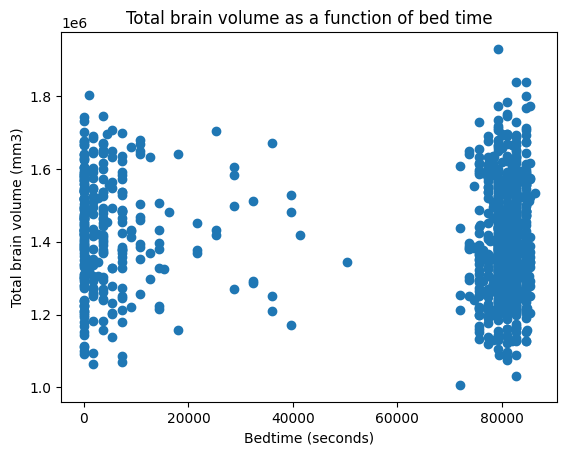

In [58]:
plt.scatter(df_final["PSQI_BedTime"],df_final["TBV"])
plt.ylabel("Total brain volume (mm3)")
plt.xlabel("Bedtime (seconds)")
plt.title("Total brain volume as a function of bed time")

#### 8.2 [Violin plot](https://chartio.com/learn/charts/violin-plot-complete-guide/)

Text(0.5, 1.0, 'Violin plot of bed times in our sample')

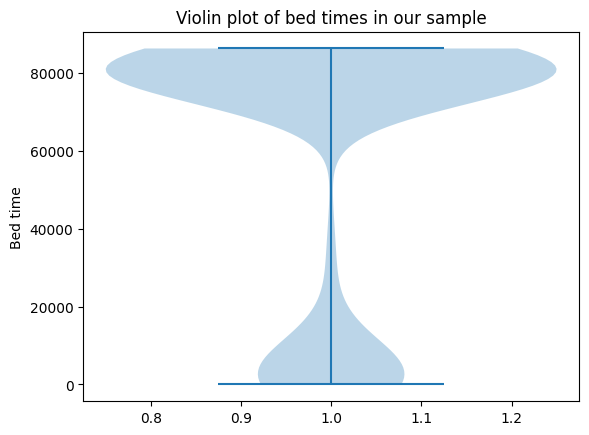

In [59]:
plt.violinplot(df_final['PSQI_BedTime'])
plt.ylabel("Bed time")
plt.title("Violin plot of bed times in our sample")

#### 8.3 Histogram plot

Text(0.5, 1.0, 'Distribution of total brain volume in our sample')

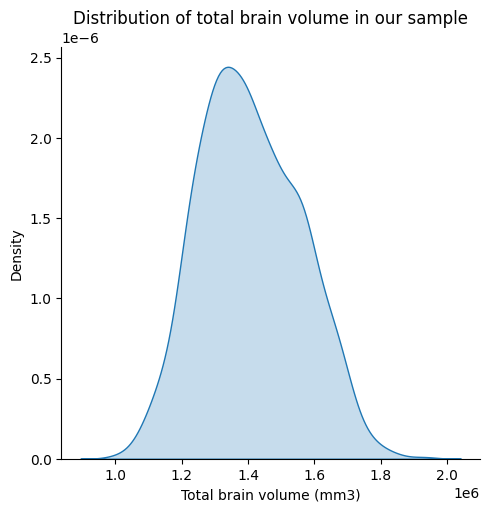

In [60]:
sns.displot(df_final,x='TBV',kind='kde',fill=True) # smoothed histogram
plt.ylabel("Density")
plt.xlabel("Total brain volume (mm3)")
plt.title("Distribution of total brain volume in our sample")

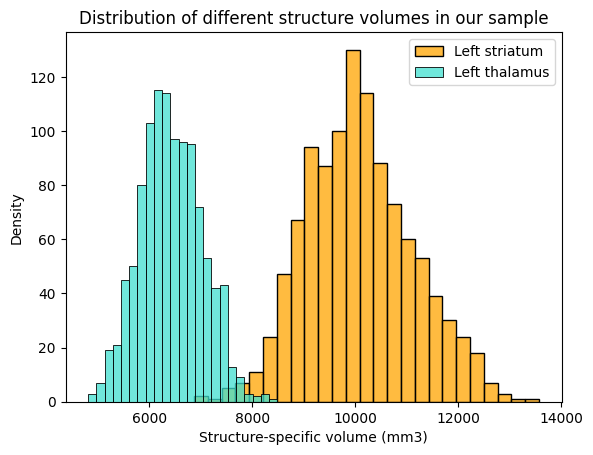

In [61]:
sns.histplot(df_final,x='Str_Left',fill=True,color='orange')
sns.histplot(df_final,x='Thal_Left',fill=True,color='turquoise')
plt.legend(['Left striatum','Left thalamus'])
plt.ylabel("Density")
plt.xlabel("Structure-specific volume (mm3)")
plt.title("Distribution of different structure volumes in our sample")
plt.show()

# 9. Loading local files into Google Colab

Nice tutorial [here](https://neptune.ai/blog/google-colab-dealing-with-files)

**TLDR:**

In [ ]:
from google.colab import files # files module from google.colab library

In [ ]:
uploaded = files.upload # you can then select files and upload them to your colab

# 10. Mini data visualization assignment
PS: this [list of named colours](https://matplotlib.org/3.5.0/gallery/color/named_colors.html) can help make your graphs nicer :)
<ol>
<li>Generate a scatter plot of TBV as a function of bed time, by gender.</li>
<li>Generate a violin plot of bed times in our sample for subjects over 30 years.</li>
<li>Generate two smoothed and superimposed histograms of bed times in subjects that are above and below 30 years.</li>
<li>Generate two superimposed histograms of the volume distributions in the left hemisphere (left striatum, thalamus and globus pallidus) and right hemisphere (right striatum, thalamus and globus pallidus)</li>
</ol>

# Supplementary

### Interactive plots with Plotly Python

* FYI: Plotly is based in Montreal!
* [Superb documentation](https://plotly.com/python/)
* Plotly express is more "higher-level" (tons of parameters are already set for you); can save you time but is less flexible

### Bringing it to the next level: making an App with Dash
* Documentation [here](https://dash.plotly.com/)
* html + Python